# MNIST 数据集进行分类
## 数据集导入
使用Scikit-Learn中的 `sklearn.datasets.fetch_openml` 进行数据读取. 可以下载的数据集可以在开放数据集网址 www.openml.org 上找到.

下载的数据集位于 `〜/ scikit_learn_data`，加载的数据集具有字典的结构，加载速度太慢可以使用本地打开方式（推荐）：

直接到 [OpenML - mnist_784](https://www.openml.org/search?type=data&status=active&id=554) 中下载数据集，然后发下下载下来的格式是 `.arff`，可以使用 `scipy.io.arff.loadarff` 打开，然后将数据集中第0个用DataFrame打开即可看到数据集.

In [1]:
# from sklearn.datasets import fetch_openml
# mnist = fetch_openml('mnist_784', version=1)
# mnist.keys()

In [2]:
from scipy.io.arff import loadarff
import pandas as pd

mnist = loadarff('C:/Users/yy/scikit_learn_data/openml/mnist_784.arff')
df = pd.DataFrame(mnist[0])
df

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,class
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'5'
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'4'
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'1'
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'9'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'2'
69996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'3'
69997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'4'
69998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'5'


数据集转化，将上述表格划分为数据集与验证集，需要注意的是：由于标签是字符串，所以转化后的结果还需要进一步转化数据格式.

In [81]:
import numpy as np
x, y = df.values[:, :-1].astype(np.float32) / 255, df.values[:, -1].astype(np.uint8)
train_x, test_x, train_y, test_y = x[:60000], x[60000:], y[:60000], y[60000:]
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(60000, 784) (10000, 784) (60000,) (10000,)


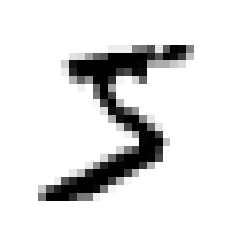

标签: 5


In [82]:
# 显示一张图片
import matplotlib as mpl
import matplotlib.pyplot as plt

sample_x, sample_y = x[0], y[0]
sample_x_figure = sample_x.reshape((28, 28))

plt.imshow(sample_x_figure, cmap='binary')
plt.axis('off')
plt.show()
print("标签:", sample_y)

## 训练二元分类器

先从简单的问题开始，如何分类一张图片是5还不是5. 可以使用随机梯度下降优化的线性分类器 `SGDClassifier`.

In [83]:
from sklearn.linear_model import SGDClassifier

train_y_5 = (train_y == 5)
test_y_5 = (test_y == 5)
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(train_x, train_y_5)

SGDClassifier(random_state=42)

In [84]:
print("简单预测一个样例:", sgd_clf.predict([sample_x]))

简单预测一个样例: [ True]


## 评估性能
### K-折交叉验证
下面使用 `sklearn.model_selection.StratifiedKFold` 实现自定义的交叉验证，使用方法和 `cross_val_score()` 类似，只不过这里将折叠数参数记为 `n_splits`（默认为5）.

In [88]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_idx, test_idx in skfolds.split(train_x, train_y_5):
    clone_clf = clone(sgd_clf)  # 每次新创建一个模型
    train_x_folds = train_x[train_idx]
    train_y_folds = train_y_5[train_idx]
    test_x_folds = train_x[test_idx]
    test_y_folds = train_y_5[test_idx]
    
    clone_clf.fit(train_x_folds, train_y_folds)
    pred = clone_clf.predict(test_x_folds)
    accuracy = sum(pred == test_y_folds)
    print(accuracy / len(pred))  # 输出准确率

0.97305
0.97465
0.9731


In [89]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, train_x, train_y_5, cv=3, scoring='accuracy')

array([0.9748, 0.9657, 0.9692])

In [94]:
print("全部非5图像的占比:", sum(~train_y_5) / len(train_y))

全部非5图像的占比: 0.90965


使用交叉验证效果感觉不错，但是其实如果一个分类器将所有图像都判断为非5，其实就可以达到90.9%的正确率，所以上述分类结果没有很强的说服力，下面使用混淆矩阵进一步说明结果.

### 混淆矩阵

混淆矩阵的列是真实值，行是预测值，$(i,j)$ 处的值表示真实值为 $i$ 时，模型预测结果为 $j$ 的个数.

使用 `sklearn.metrics.confusion_matrix(true_y, pred_y)` 可以很容易地获得混淆矩阵. 而获得预测值的很好的一个方法是通过交叉验证返回的预测结果 `sklearn.model_selection.cross_val_predict`. 由于只使用了训练集，使用交叉验证可以保证将训练集进一步划分为更小的训练集与验证集，保证了预测的干净（预测数据没有再训练中出现）

In [95]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

train_y_pred = cross_val_predict(sgd_clf, train_x, train_y_5, cv=3)
confusion_matrix(train_y_5, train_y_pred)

array([[53613,   966],
       [  840,  4581]], dtype=int64)

#### 定义
在二分类的混淆矩阵的每个元素都有对应的名称：假设真实值与预测结果的列表排列均为 `[假, 真]`，则每个位置的元素对应名称如下所示：

- `(1,1)` 表示真负类(TN).
- `(1,2)` 表示假正类(FP).
- `(2,1)` 表示假负类(FN).
- `(2,2)` 表示真正类(TP).


> 记忆方法非常简单，名称中第一个“真与假”表示是否预测正确，第二个“正与负”表示预测结果的类别.

有两个常用参数：
$$
\text{精度} = \frac{TP}{TP+FP}\qquad \text{召回率} = \frac{TP}{TP+FN}
$$

- **精度(Precision)**：预测结果是真的时候，有多大概率是对的.
- **召回率(Recall)**：标签为真的时候，能有多大的概率预测对.（如果用假设检验的第一类错误来理解，设原假设为样本标签为真，那么“1-召回率”就是第一类错误）

一种评估精度与召回率的方法是 $F_1$ 参数（两者的调和平均数）：
$$
F_1 = \frac{2}{\frac{1}{\text{精度}}+\frac{1}{\text{召回率}}}
$$

用法：使用F1一般是希望精度与召回率同时较高时所用，但是对于特定问题，可能仅需要某一种参数越高越好. 例如检测小偷，肯定希望召回率越高越好，也就是所谓的“宁可错杀一千，不可放过一个”；而视频筛选中，希望精度越高越好，因为我们希望即使错筛了很多好的视频，但是留下来的都是好的就行.

**精度-召回率曲线**：模型通过得分是否超过阈值判断样本属于的类别，通过设定不同的阈值，从而可以得到不同的PR值，绘制出的曲线，一般称为P-R曲线，一般也用P-R曲线与x轴围成的面积(Area Under Curve, AUC)评估模型好坏（越大越好），面积计算可以使用 `sklearn.metrics.auc`.

#### 实现
Scikit-Learn中可以很容易地计算出精度，召回率和 $F_1$ 参数，分别为 `sklearn.metrics` 中的 `precision_score, recall_score, f1_score`，代入预测值与真实值即可计算出结果.

In [106]:
from sklearn.metrics import precision_score, recall_score, f1_score
print("精度:", precision_score(train_y_5, train_y_pred))
print("召回率:", recall_score(train_y_5, train_y_pred))
print("F1:", f1_score(train_y_5, train_y_pred))

精度: 0.8258518117901569
召回率: 0.8450470392916436
F1: 0.8353391684901532


##### PR曲线
`SGD` 模型输出的是对样本的打分，而判断是否属于哪类则是通过阈值来确定的，默认阈值为 `0`，对于二分类问题，阈值与召回率成负相关关系（因为如果将所有都预测为真，则召回率一定很好），我们可以根据不同的阈值从而获得不同的预测结果，对应不同的模型，从而绘制出精度与召回率的关系图.

首先需要求出模型对每个样本的打分，还是用过 `cross_val_predict` 获得，但是这里需要从模型的 `decision_function` 获得评分，而不是最后的预测结果，使用 `method` 可以选择最后模型输出的函数，默认为 `method='predict'`.

最后使用 [`sklearn.metrics.precision_recall_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html) 不同阈值下的精度与召回率的值，使用方法为 

- `precision_recall_curve(y_true, probas_pred)`，第一个参数为标签真实值，第二个参数为所有可能的得分. 于是阈值会根据全部得分从小到大逐一选择，并求出对应精度与召回率. 返回值：精度，召回率，阈值.

> 注意：精度和召回率的维数为 `(n_thresholds + 1,)` 比阈值大1，精度最后一个元素为 `1`，而召回率最后一个元素为 `0`，绘图时记得将其删去.

In [103]:
# 使用decision_function获得样本的打分
sgd_clf.decision_function(train_x[:10])

array([ 0.49010364, -5.79399718, -8.1066338 , -4.37994204, -4.7884292 ,
       -4.57067767, -4.47894354, -5.7897907 , -2.49371734, -3.34911346])

In [108]:
from sklearn.metrics import precision_recall_curve

train_y_scores = cross_val_predict(sgd_clf, train_x, train_y_5, cv=3, method='decision_function')
precisions, recalls, thresholds = precision_recall_curve(train_y_5, train_y_scores)

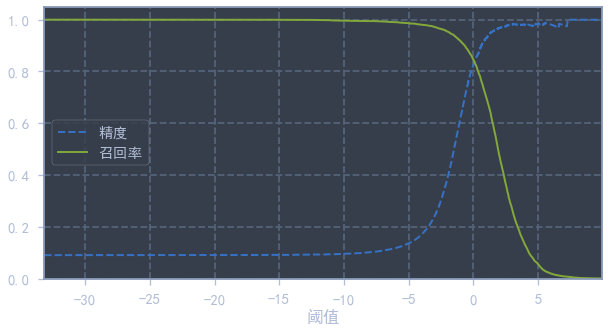

In [123]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(10, 5))
    plt.plot(thresholds, precisions[:-1], "b--", label="精度")
    plt.plot(thresholds, recalls[:-1], "g-", label="召回率")
    plt.legend()
    plt.xlabel("阈值")
    plt.axis([thresholds.min(), thresholds.max(), 0, 1.05])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [178]:
recall_for_90_precision = recalls[np.argmax(precisions >= 0.90)]  # 利用np.argmax可以找到第一个true的下标

曲线下面积为: 0.8907556859354993


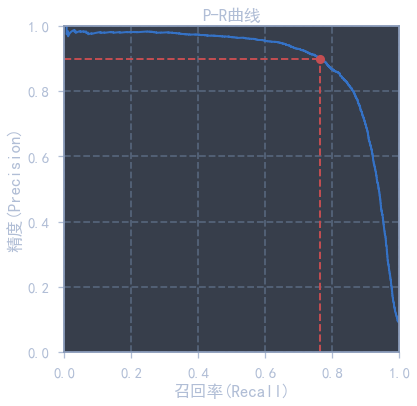

In [180]:
from sklearn.metrics import auc

def plot_precision_vs_recall(precisions, recalls):
    plt.figure(figsize=(6, 6))
    plt.plot(recalls, precisions, 'b-', lw=2)
    plt.xlabel('召回率(Recall)')
    plt.ylabel('精度(Precision)')
    plt.axis([0, 1, 0, 1])
    plt.title('P-R曲线')
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_for_90_precision, recall_for_90_precision], [0, 0.9], 'r--')
plt.plot([0, recall_for_90_precision], [0.9, 0.9], 'r--')
plt.plot([recall_for_90_precision], [0.9], 'ro')
print("曲线下面积为:", auc(recalls, precisions))

##### ROC曲线

另一种常用的曲线称为 **受试者工作特征曲线(Receiver Operating Characteristic Curve, ROC)**，绘制的是真正类率（召回率）和假正类率（FPR），它们的定义如下
$$
\text{假正类率FPR} = \frac{FP}{TN+FP},\qquad \textbf{真负类率TPR(特异度)} = 1-FPR = \frac{TN}{TN+FP}
$$
不难发现，这种什么率就是按照混淆矩阵的行占比来定义的，例如上述两个FPR和TPR就分别是**全部负类样本中**被错误预测的概率的和被正确预测的概率，特别的TPR还被称为**特异度**.

实际使用中，我们会直接画出ROC曲线，然后用曲线下面积AUC来评判模型的好坏.

使用 [`sklearn.metrics.roc_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve) 获得 `fpr, tpr, theresholds` 对应结果（与 `precision_recall_curve` 曲线返回值相同）

> 注：由于有 `drop_intermediatebool=True` 参数，会自动舍弃一些次优阈值，使得曲线显示更加清晰，所以返回结果中阈值个数可能远小于输入的样本个数.

In [161]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, thresholds = roc_curve(train_y_5, train_y_scores)
print("ROC得分:", roc_auc_score(train_y_5, train_y_scores))

ROC得分: 0.970452271342763


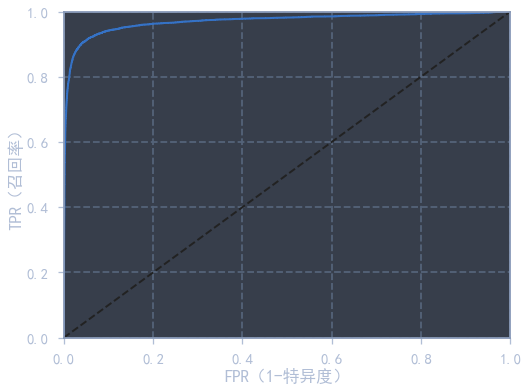

ROC得分: 0.970452271342763


In [182]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, lw=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('FPR（1-特异度）')
    plt.ylabel('TPR（召回率）')
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr, label='SGD')
plt.savefig("./figure/ROC曲线")
plt.show()
print("ROC得分:", auc(fpr, tpr))

使用随机森林 `RandomForestClassifier` 与 `SGD` 进行对比实验. 在随机森林模型中，打分是根据概率分布得到的，使用 `.predict_proba()` 可以得到样本对应的标签概率分布率，然后做正例列的切片即可得到得分.

In [168]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, train_x, train_y_5, cv=3, method='predict_proba')

In [172]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(train_y_5, y_scores_forest)
print("随机森林ROC评分:", roc_auc_score(train_y_5, y_scores_forest))  # 从得分可以明显看出，随机森林的二分类效果好于SGD

随机森林ROC评分: 0.9983400347444625


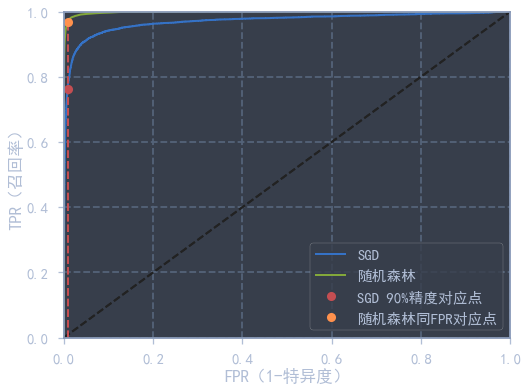

In [189]:
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr, label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, label='随机森林')
fpr_for_90_percision_sgd = fpr[np.argmax(tpr >= recall_for_90_precision)]
tpr_for_sgd_fpr_forest = tpr_forest[np.argmax(fpr_forest >= fpr_for_90_percision_sgd)]
plt.plot([fpr_for_90_percision_sgd, fpr_for_90_percision_sgd], [0, recall_for_90_precision], 'r--', lw=2)
plt.plot([0, fpr_for_90_percision_sgd], [recall_for_90_precision, recall_for_90_precision], 'r--', lw=2)
plt.plot([fpr_for_90_percision_sgd], [recall_for_90_precision], 'ro', label='SGD 90%精度对应点')
plt.plot([fpr_for_90_percision_sgd, fpr_for_90_percision_sgd], [0, tpr_for_sgd_fpr_forest], 'r--', lw=2)
plt.plot([0, fpr_for_90_percision_sgd], [tpr_for_sgd_fpr_forest, tpr_for_sgd_fpr_forest], 'r--', lw=2)
plt.plot([fpr_for_90_percision_sgd], [tpr_for_sgd_fpr_forest], 'yo', label='随机森林同FPR对应点')
plt.legend()
plt.show()